In [ ]:
%matplotlib notebook

# Solar Data Processing with Python

Now we have a grasp of the basics of python and know what kind of solar data exist using SunPy, but the whole reason for downloading python in the first place was to analyze solar data. Let's take a closer look at examples of solar data analysis. 

## Fitting A Gaussian to Data.


One of the most common data types in solar data processing is a time series. A time series is a measurement of how one physical parameter changes as a function of time. This example shows how to fit a gaussian to a spectral line. In this example, it will be as "real world" as possible.

First, let's import some useful libraries. 

In [2]:
from datetime import datetime, timedelta #we saw these in the last tutorial

import numpy as np 
from astropy.io import fits #how to read .fits files
from astropy.modeling import models, fitting #some handy fitting tools from astropy
import matplotlib.pyplot as plt 
from scipy.integrate import trapz #numerical itegration tool
import astropy.units as u #units!!
import sunpy #solar data analysis tools
import sunpy.data.sample #Data interaction tools 


In [5]:
sunpy.data.download_sample_data()

#Download some sample data


/Users/mskirk/anaconda3/lib/python3.6/site-packages/sunpy/data/_sample.py:160: UserWarning: File AIA20110607_063301_0131_lowres.fits not found.
  warnings.warn("File {} not found.".format(filename))
/Users/mskirk/anaconda3/lib/python3.6/site-packages/sunpy/data/_sample.py:160: UserWarning: File AIA20110607_063302_0171_lowres.fits not found.
  warnings.warn("File {} not found.".format(filename))
/Users/mskirk/anaconda3/lib/python3.6/site-packages/sunpy/data/_sample.py:160: UserWarning: File AIA20110607_063302_0211_lowres.fits not found.
  warnings.warn("File {} not found.".format(filename))
/Users/mskirk/anaconda3/lib/python3.6/site-packages/sunpy/data/_sample.py:160: UserWarning: File AIA20110607_063303_0335_lowres.fits not found.
  warnings.warn("File {} not found.".format(filename))
/Users/mskirk/anaconda3/lib/python3.6/site-packages/sunpy/data/_sample.py:160: UserWarning: File AIA20110607_063305_0094_lowres.fits not found.
  warnings.warn("File {} not found.".format(filename))
/User

Next we need to load in the data set we want to work with:

In [6]:
filename = sunpy.data.sample.GBM_TIMESERIES


In [9]:
hdulist = fits.open(filename)

So what did we get when we opened the file? Let's take a look:

In [10]:
len(hdulist)

4

We got 4 items in the list. Lets take a look at the first one: 

In [11]:
hdulist[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CREATOR = 'GBM_SCI_Reader.pl v1.19' / Software and version creating file        
FILETYPE= 'PHAII   '           / Name for this type of FITS file                
FILE-VER= '1.0.0   '           / Version of the format for this filetype        
TELESCOP= 'GLAST   '           / Name of mission/satellite                      
INSTRUME= 'GBM     '           / Specific instrument used for observation       
DETNAM  = 'NAI_05  '           / Individual detector name                       
OBSERVER= 'Meegan  '        

It looks like this data is from the GLAST telescope measuring gamma rays. Let's take a look at the second item:

In [12]:
hdulist[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   10 / width of table in bytes                        
NAXIS2  =                  128 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    3 / number of fields in each row                   
TTYPE1  = 'CHANNEL '           / label for field   1                            
TFORM1  = '1I      '           / data format of field: 2-byte INTEGER           
TUNIT1  = 'none    '           / physical unit of field                         
TLMIN1  =                    0 / Channel numbers are non-negative               
TLMAX1  =                  1

Alright, now we are getting somewhere. This has data in units of 'keV' and max/min measurements. Let's take a look at the other elements of the list we got:

In [13]:
hdulist[2].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                  278 / width of table in bytes                        
NAXIS2  =                19775 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    5 / number of fields in each row                   
TTYPE1  = 'COUNTS  '           / label for field   1                            
TFORM1  = '128I    '           / data format of field: 2-byte INTEGER           
TZERO1  =                32768 / offset for unsigned integers                   
TSCAL1  =                    1 / data are not scaled                            
TUNIT1  = 'count   '        

In [14]:
hdulist[3].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   16 / width of table in bytes                        
NAXIS2  =                   10 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    2 / number of fields in each row                   
TTYPE1  = 'START   '           / label for field   1                            
TFORM1  = '1D      '           / data format of field: 8-byte DOUBLE            
TUNIT1  = 's       '           / physical unit of field                         
TZERO1  =     329097602.000000 / Offset (s), equal to TRIGTIME                  
TTYPE2  = 'STOP    '        

So it looks like we are working with some energy counts data, temportal information, quality measurements, etc. 

### Plotting Spectral Data
Let's take a look at some of the data we've got. 

In [15]:
len(hdulist[2].data)

19775

In [16]:
hdulist[2].data.names

['COUNTS', 'EXPOSURE', 'QUALITY', 'TIME', 'ENDTIME']

In [17]:
hdulist[2].data["COUNTS"]

array([[  9,  34,  30, ...,   8, 274, 104],
       [  7,  20,  29, ...,  15, 278,  99],
       [  8,  23,  34, ...,  14, 236, 139],
       ...,
       [ 15,  29,  40, ...,  14, 223, 112],
       [  6,  33,  36, ...,   7, 266, 112],
       [  7,  30,  36, ...,   8, 236, 101]], dtype=uint16)

In [18]:
hdulist[2].data["COUNTS"].shape

(19775, 128)

There is a large array of counts at 128 different energies. Let's take a look at the lowest energy measurements: 

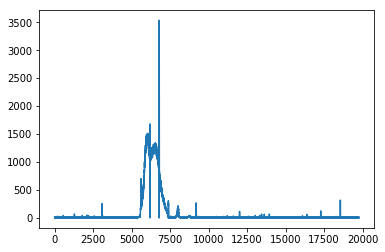

In [19]:
plt.plot(hdulist[2].data["counts"][:,0])


So now we have a plot of counts over some perieod of time. We can see there is one major spike in the data. Let's filter the data so that we just have the major peak without the spike. 

In [20]:
w = np.logical_and(hdulist[2].data["counts"][:,0] > 300, hdulist[2].data["counts"][:,0] < 2000)

In [21]:
w

array([False, False, False, ..., False, False, False])

This function, `np.logical_and`, returns a logical. We can see that `w` is now an array of true and false values. To take a subsection of our data where our filter is true:

In [22]:
counts = hdulist[2].data["counts"][:,0][w]

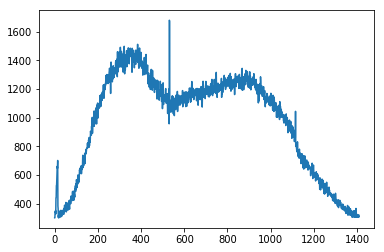

In [23]:
plt.plot(counts)

In [24]:
counts
len(counts)

1410

Now, it is good to add some units to data when you can. The header of the file tells us what the units are, but in this case, counts have no units. 

### Fitting the data with a Gaussian

Now that we have extracted a detection feature from the whole data. Now let's say we want to fit it with a gaussian. Do do this we will make use of a couple of packages in in AstroPy. We will initialize the gaussian fit with some approximations (max, center, FWHM): 

In [25]:
g_init = models.Gaussian1D(1500, 300, 100)

Now let's define a fitting method and produce a fit:

In [26]:
fit_g = fitting.LevMarLSQFitter()

Since this fitting routine expects both X and Y coordinate data, we need to define an X vector:

In [27]:
t=np.arange(0,len(counts))

In [28]:
g = fit_g(g_init, t, counts)

Let's take a look at some of the qualities of our fitted gaussian:

In [29]:
g.mean

Parameter('mean', value=619.6492367933208)

In [30]:
g.stddev

Parameter('stddev', value=480.68572062988443, bounds=(1.1754943508222875e-38, None))

In [31]:
g.amplitude

Parameter('amplitude', value=1345.2643084478582)

In [32]:
g

<Gaussian1D(amplitude=1345.26430845, mean=619.64923679, stddev=480.68572063)>

Our guesses wern't too bad, but we over estimated the Standard Deviation by about a factor of 5. The variable `g` has the fitted parameters of our gaussian but it doesn't actually contain an array. To plot it over the data, we need to create an array of values. We will make an array from 0 to 1410 with 2820 points in it. 

In [33]:
x = np.linspace(0, 1410, 2820)

To find the values of our fit at each location, it is easy:

In [34]:
y = g(x)

Now we can plot it:

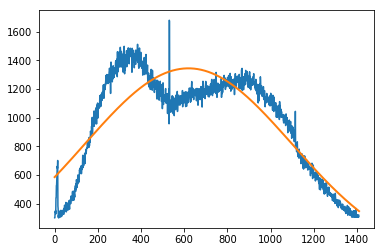

In [35]:
plt.plot(counts)
plt.plot(x, y, linewidth=2)

That isn't a very good fit. If we chose a more clever way to filter our data, or possibly fit two gaussians that could improve things. 

### Ingegrating under the curve. 

Let's find the area under the curve we just created. We can numerically integrate it easily:

In [36]:
intensity = trapz(y,x)

In [37]:
intensity

1379801.5650536548

## Creating a Histogram from a Map Image

Often when working with images, it is useful to look at a histogram of the values to understand how the image is constructed. When working with solar data, we can use the `Map` object we saw earlier to help us construct one. 

First let's download some more libraries: 

In [38]:
import sunpy.map
from astropy.coordinates import SkyCoord
from sunpy.data.sample import AIA_171_IMAGE

We first create the Map using the sample data and we will create a submap of a quiet region.

In [39]:
aia = sunpy.map.Map(AIA_171_IMAGE)
bl = SkyCoord(-400 * u.arcsec, 0 * u.arcsec, frame=aia.coordinate_frame)
tr = SkyCoord(0 * u.arcsec, 400 * u.arcsec, frame=aia.coordinate_frame)
aia_smap = aia.submap(bl, tr)

We now create a histogram of the data in this region.

In [40]:
dmin = aia_smap.min()
dmax = aia_smap.max()
num_bins = 50
hist, bins = np.histogram(aia_smap.data, bins=np.linspace(dmin, dmax, num_bins))
width = 0.7 * (bins[1] - bins[0])
x = (bins[:-1] + bins[1:]) / 2

Let’s plot the histogram as well as some standard values such as mean upper, and lower value and the one-sigma range.

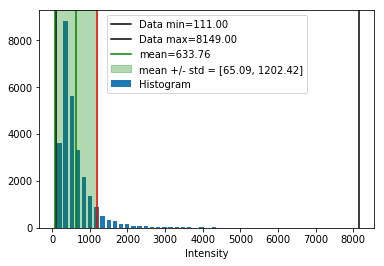

In [41]:
plt.figure()
plt.bar(x, hist, align='center', width=width, label='Histogram')
plt.xlabel('Intensity')
plt.axvline(dmin, label='Data min={:.2f}'.format(dmin), color='black')
plt.axvline(dmax, label='Data max={:.2f}'.format(dmax), color='black')
plt.axvline(aia_smap.data.mean(),
            label='mean={:.2f}'.format(aia_smap.data.mean()), color='green')
one_sigma = np.array([aia_smap.data.mean() - aia_smap.data.std(),
                      aia_smap.data.mean() + aia_smap.data.std()])
plt.axvspan(one_sigma[0], one_sigma[1], alpha=0.3, color='green',
            label='mean +/- std = [{0:.2f}, {1:.2f}]'.format(
            one_sigma[0], one_sigma[1]))
plt.axvline(one_sigma[0], color='green')
plt.axvline(one_sigma[1], color='red')
plt.legend()
plt.show()

Finally let’s overplot what the one-sigma range means on the map



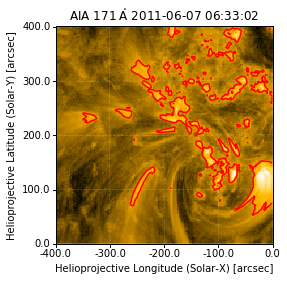

In [42]:
fig = plt.figure()
fig.add_subplot(projection=aia_smap)
aia_smap.plot()
levels = one_sigma / dmax * u.percent * 100
aia_smap.draw_contours(levels=levels, colors=['red', 'green'])
plt.show()